# Entrypoint Graph

This example shows how builders that repeatedly set a new entry point, and how the final graph would look like.

First we define a basic builder. You can check the basic example for more details.

In [1]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph

from assistant_core.builder import BuilderContext, SingleAgent, BaseBuilder
from assistant_core.factories import BaseAgentFactory
from assistant_core.nodes import AgentNode, PromptNode
from assistant_core.settings import OPENAI_API_KEY

In [2]:
ASSISTANT_PROMPT = """
You are a helpful assistant.
"""


class GeneralAssistantFactory(BaseAgentFactory):
    """Factory for creating a general-purpose assistant agent."""

    def create_graph_builder(self):
        return StateGraph(MessagesState)

    def create_agent_node(self):
        return AgentNode(
            name="assistant",
            model=self.model,
            prompts=[ASSISTANT_PROMPT],
        )

In [3]:
context = BuilderContext(
    GeneralAssistantFactory(
        {
            "OPENAI_API_KEY": OPENAI_API_KEY,
        }
    )
)

Create a demo builder that creates a dummy node and set it at the entrypoint.

In [4]:
class CustomBuilderWithEntrypoint(BaseBuilder):
    def __init__(self, custom_node_name: str):
        super().__init__()
        self.custom_node_name = custom_node_name

    def build(self, context):
        custom_node = PromptNode(
            name=self.custom_node_name,
            prompt=f"Testing the custom node {self.custom_node_name}",
        )

        context.graph_builder.add_node(
            custom_node.name,
            custom_node,
        )

        context.entrypoint = custom_node.name

In [5]:
agent = SingleAgent()
agent.add_builder(CustomBuilderWithEntrypoint("custom_node_1"))
agent.add_builder(CustomBuilderWithEntrypoint("custom_node_2"))
agent.add_builder(CustomBuilderWithEntrypoint("custom_node_3"))

workflow = agent.make(context)
graph = workflow.compile(checkpointer=MemorySaver())

This is how the final graph looks like:

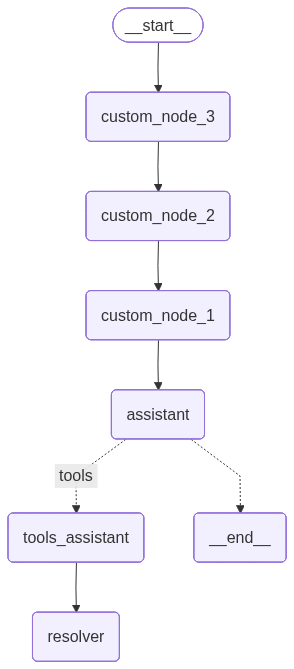

In [6]:
display(Image(graph.get_graph().draw_mermaid_png()))


Execute the graph for a basic example:

In [7]:
async for step in graph.astream(
    {"messages": [{"role": "user", "content": "Hello, what are we doing?"}]},
    config={"configurable": {"thread_id": "test_entrypoint"}},
):
    print(step)

{'custom_node_3': {'messages': [SystemMessage(content='Testing the custom node custom_node_3', additional_kwargs={}, response_metadata={}, id='895c661a-69d1-414e-8b2a-3930403496da')]}}
{'custom_node_2': {'messages': [SystemMessage(content='Testing the custom node custom_node_2', additional_kwargs={}, response_metadata={}, id='6ca084a5-1b63-418a-ad15-b1a3f5177231')]}}
{'custom_node_1': {'messages': [SystemMessage(content='Testing the custom node custom_node_1', additional_kwargs={}, response_metadata={}, id='8586300d-afff-416c-86b6-df68b8d6859e')]}}
{'assistant': {'messages': [AIMessage(content=[{'type': 'text', 'text': 'We’re testing three custom nodes: custom_node_1, custom_node_2, and custom_node_3. Want to run a quick test input or review their current outputs/status?', 'annotations': []}], additional_kwargs={'reasoning': {'id': 'rs_09fd4d6f228b3faf0068e03f87a5bc81a3b4f06a887a318c94', 'summary': [], 'type': 'reasoning'}}, response_metadata={'id': 'resp_09fd4d6f228b3faf0068e03f87222c